<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S8_Custom_Resnet/S8_CUSTOM_RESNET_CIFAR_GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running a custom ResNet model from models.py
## Running a model on CIFAR10 dataset
## Leveraing GradCam to produce activation maps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autoreload 2
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/navrat/EVA_phase1_2022_23 -q --quiet
!mv EVA_phase1_2022_23/CIFAR_Pytorch/* .
print("Loaded EVA8 Modules and Models")

!rm -rf EVA_phase1_2022_23

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA8 Modules and Models
  Preparing metadata (setup.py) ... done


## Loading train and test datasets

In [3]:
from utils import *
from main import *

dataset = dataset_cifar10(batch_size=128)

CUDA availability ? True


In [4]:
# Train dataloader
trainloader = dataset.loader(train_flag=True)

# Test dataloader
testloader = dataset.loader(train_flag=False)

target_classes = dataset.classes

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


In [5]:
dataset.data_summary_stats()

training data
Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
testing data
Files already downloaded and verified
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]
total data
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


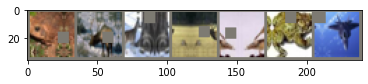

['frog', 'deer', 'deer', 'deer', 'bird', 'frog', 'plane']


In [6]:
# # sample training images
plot_sample_images(trainloader, target_classes, 7)

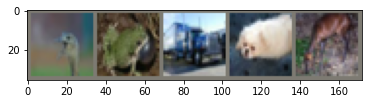

['bird', 'frog', 'truck', 'dog', 'deer']


In [7]:
# sample testing images
plot_sample_images(testloader, target_classes, 5)

In [8]:
# Defining the model - RESTNET
from models.custom_resnet import *
import torch

# Loading ResNet18 Model
net = Custom_ResNet()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


In [9]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
    

## Implementing one cycle policy

In [ ]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

  0%|          | 0/500 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.71E-02


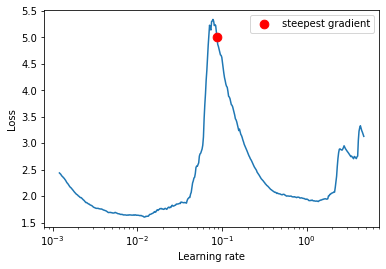

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.08707224849239917)

In [ ]:
# One cycle implementation
net_exp = copy.deepcopy(net)
optimizer = torch.optim.SGD(net_exp.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=500)
lr_finder.plot()

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.012082709350447767


In [ ]:
# Load train and test model
# from main import *
# criterion, optimizer, scheduler, n_epochs = model_training_setup(net)
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# Load train and test model
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,# %of epochs spent increasing LR
                                                div_factor=25,
                                                three_phase=False, # False to not annihilate
                                                final_div_factor=10, # since lr_min needs to be 1/10th of max LR
                                                anneal_strategy='linear'
                                                )
net, history = fit_model_onecycle_LR(
    net=net, device=device,
    criterion = criterion,
    train_loader=trainloader, test_loader=testloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.00048330837401791067)


Batch_id=390 Loss=1.51421 Accuracy=45.09%: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s]



Test set: Average loss: 1.4460, Accuracy: 5070/10000 (50.70%)

EPOCH: 2 (LR: 0.0029011385167751736)


Batch_id=390 Loss=1.13945 Accuracy=59.41%: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 1.0334, Accuracy: 6406/10000 (64.06%)

EPOCH: 3 (LR: 0.005318968659532436)


Batch_id=390 Loss=0.97830 Accuracy=65.76%: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]



Test set: Average loss: 0.9030, Accuracy: 6949/10000 (69.49%)

EPOCH: 4 (LR: 0.007736798802289699)


Batch_id=390 Loss=0.85095 Accuracy=70.43%: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]



Test set: Average loss: 0.7448, Accuracy: 7434/10000 (74.34%)

EPOCH: 5 (LR: 0.010154628945046961)


Batch_id=390 Loss=0.75435 Accuracy=73.99%: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]



Test set: Average loss: 0.6341, Accuracy: 7834/10000 (78.34%)

EPOCH: 6 (LR: 0.011955748196058215)


Batch_id=390 Loss=0.68144 Accuracy=76.62%: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]



Test set: Average loss: 0.8419, Accuracy: 7195/10000 (71.95%)

EPOCH: 7 (LR: 0.011328957648503737)


Batch_id=390 Loss=0.62141 Accuracy=78.40%: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]



Test set: Average loss: 0.6300, Accuracy: 7940/10000 (79.40%)

EPOCH: 8 (LR: 0.01070216710094926)


Batch_id=390 Loss=0.56765 Accuracy=80.44%: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]



Test set: Average loss: 0.5484, Accuracy: 8219/10000 (82.19%)

EPOCH: 9 (LR: 0.010075376553394782)


Batch_id=390 Loss=0.52498 Accuracy=81.85%: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]



Test set: Average loss: 0.4986, Accuracy: 8289/10000 (82.89%)

EPOCH: 10 (LR: 0.009448586005840304)


Batch_id=390 Loss=0.49669 Accuracy=82.81%: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]



Test set: Average loss: 0.6957, Accuracy: 7791/10000 (77.91%)

EPOCH: 11 (LR: 0.008821795458285826)


Batch_id=390 Loss=0.46232 Accuracy=83.99%: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]



Test set: Average loss: 0.4299, Accuracy: 8563/10000 (85.63%)

EPOCH: 12 (LR: 0.008195004910731348)


Batch_id=390 Loss=0.43242 Accuracy=84.91%: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.5528, Accuracy: 8295/10000 (82.95%)

EPOCH: 13 (LR: 0.00756821436317687)


Batch_id=390 Loss=0.40795 Accuracy=85.97%: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]



Test set: Average loss: 0.4149, Accuracy: 8649/10000 (86.49%)

EPOCH: 14 (LR: 0.006941423815622393)


Batch_id=390 Loss=0.38717 Accuracy=86.59%: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]



Test set: Average loss: 0.3686, Accuracy: 8731/10000 (87.31%)

EPOCH: 15 (LR: 0.006314633268067914)


Batch_id=390 Loss=0.37367 Accuracy=87.06%: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 0.3769, Accuracy: 8785/10000 (87.85%)

EPOCH: 16 (LR: 0.005687842720513436)


Batch_id=390 Loss=0.34384 Accuracy=87.92%: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]



Test set: Average loss: 0.3802, Accuracy: 8765/10000 (87.65%)

EPOCH: 17 (LR: 0.005061052172958959)


Batch_id=390 Loss=0.32359 Accuracy=88.74%: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]



Test set: Average loss: 0.4284, Accuracy: 8651/10000 (86.51%)

EPOCH: 18 (LR: 0.004434261625404481)


Batch_id=390 Loss=0.30634 Accuracy=89.29%: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]



Test set: Average loss: 0.3532, Accuracy: 8900/10000 (89.00%)

EPOCH: 19 (LR: 0.0038074710778500023)


Batch_id=390 Loss=0.28727 Accuracy=89.89%: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]



Test set: Average loss: 0.3384, Accuracy: 8904/10000 (89.04%)

EPOCH: 20 (LR: 0.0031806805302955245)


Batch_id=390 Loss=0.26960 Accuracy=90.68%: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]



Test set: Average loss: 0.3228, Accuracy: 8924/10000 (89.24%)

EPOCH: 21 (LR: 0.0025538899827410467)


Batch_id=390 Loss=0.24646 Accuracy=91.35%: 100%|██████████| 391/391 [00:30<00:00, 12.63it/s]



Test set: Average loss: 0.3060, Accuracy: 8995/10000 (89.95%)

EPOCH: 22 (LR: 0.001927099435186569)


Batch_id=390 Loss=0.22860 Accuracy=92.02%: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]



Test set: Average loss: 0.3126, Accuracy: 9009/10000 (90.09%)

EPOCH: 23 (LR: 0.0013003088876320911)


Batch_id=390 Loss=0.21250 Accuracy=92.49%: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]



Test set: Average loss: 0.2764, Accuracy: 9103/10000 (91.03%)

EPOCH: 24 (LR: 0.0006735183400776133)


Batch_id=390 Loss=0.18759 Accuracy=93.49%: 100%|██████████| 391/391 [00:31<00:00, 12.31it/s]



Test set: Average loss: 0.2681, Accuracy: 9121/10000 (91.21%)



In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
model_save_name = 's8_custom_resnet18_classifier.pt'
path = F"/content/gdrive/MyDrive/eva8_models/{model_save_name}" 
torch.save(net.state_dict(), path)

In [13]:
model_save_name = 's8_custom_resnet18_classifier.pt'
path = F"/content/gdrive/MyDrive/eva8_models/{model_save_name}"
net.load_state_dict(torch.load(path))

<All keys matched successfully>

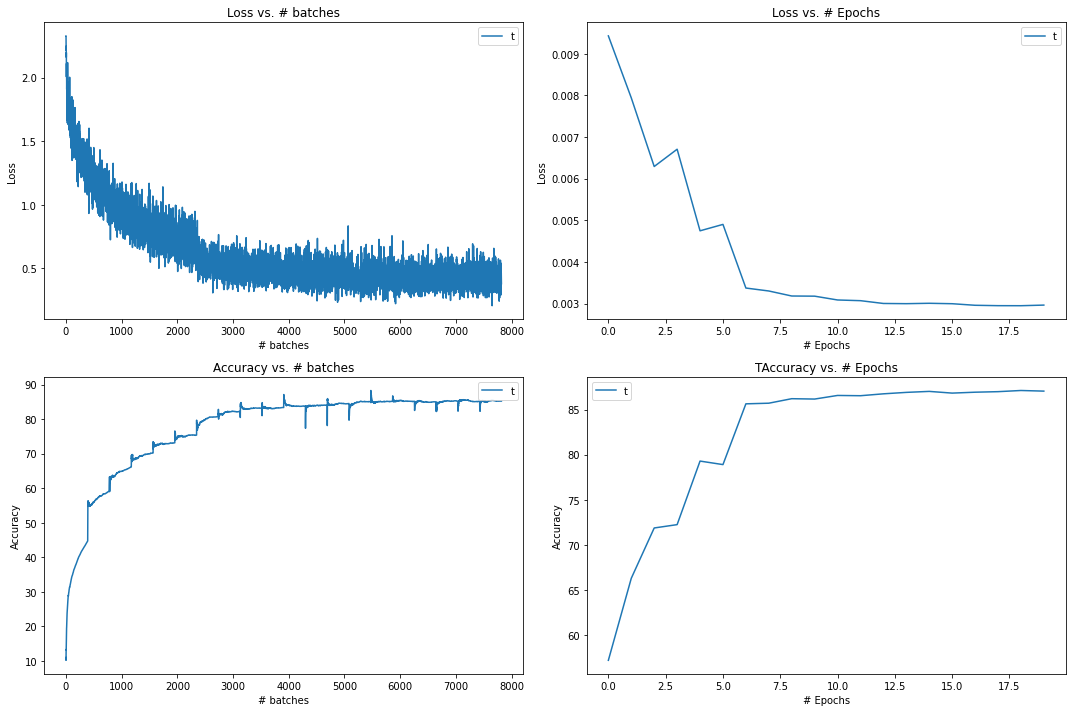

In [ ]:
from utils import plot_evolution_graph
plot_evolution_graph(trainObj, testObj)

In [21]:
model_eval_f(net, device, trainloader, target_classes) # train performance report


Test set: Average loss: 0.1717, Accuracy: 47014/50000 (94.03%)


 class wise performance: 

  classes  accuracy
0   plane     91.22
1     car     97.46
2    bird     89.14
3     cat     94.24
4    deer     87.50
5     dog     96.24
6    frog     95.46
7   horse     95.80
8    ship     96.60
9   truck     96.62
              precision    recall  f1-score   support

        bird       0.93      0.91      0.92      5000
         car       0.98      0.97      0.98      5000
         cat       0.87      0.89      0.88      5000
        deer       0.93      0.94      0.94      5000
         dog       0.92      0.88      0.90      5000
        frog       0.96      0.96      0.96      5000
       horse       0.96      0.95      0.96      5000
       plane       0.93      0.96      0.95      5000
        ship       0.97      0.97      0.97      5000
       truck       0.97      0.97      0.97      5000

    accuracy                           0.94     50000
   macro avg       0.94      0.94    

In [20]:
model_eval_f(net, device, testloader, target_classes) # test performance report


Test set: Average loss: 0.2693, Accuracy: 9121/10000 (91.21%)


 class wise performance: 

  classes  accuracy
0   plane      87.3
1     car      96.4
2    bird      81.7
3     cat      91.6
4    deer      84.8
5     dog      95.6
6    frog      93.3
7   horse      91.9
8    ship      95.3
9   truck      94.2
              precision    recall  f1-score   support

        bird       0.90      0.87      0.89      1000
         car       0.95      0.96      0.96      1000
         cat       0.82      0.82      0.82      1000
        deer       0.90      0.92      0.91      1000
         dog       0.88      0.85      0.86      1000
        frog       0.91      0.96      0.93      1000
       horse       0.95      0.93      0.94      1000
       plane       0.92      0.92      0.92      1000
        ship       0.96      0.95      0.96      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91     


 # of incorrect images predicted in test dataset of 10000: 879


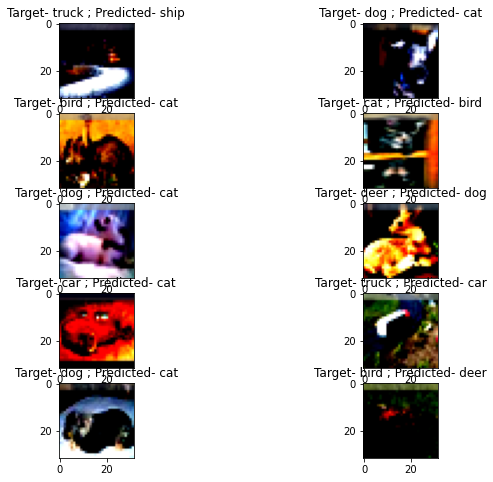



 crosstab of incorrect prediction to understand patterns: 



Predicted,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
Actual,,,,,,,,,,
bird,0,0,18,36,12,27,5,25,2,2
car,0,0,1,0,0,1,0,4,3,27
cat,23,2,0,23,77,24,15,9,3,7
deer,18,1,20,0,11,13,16,3,1,1
dog,16,0,98,12,0,10,13,1,0,2
frog,12,1,13,10,0,0,2,3,2,1
horse,10,0,10,18,19,1,0,6,0,3
plane,17,7,10,2,2,6,0,0,21,16
ship,3,5,3,0,0,3,1,22,0,10


In [18]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10)  # test misclassified images and crosstab report


 # of incorrect images predicted in test dataset of 10000: 879


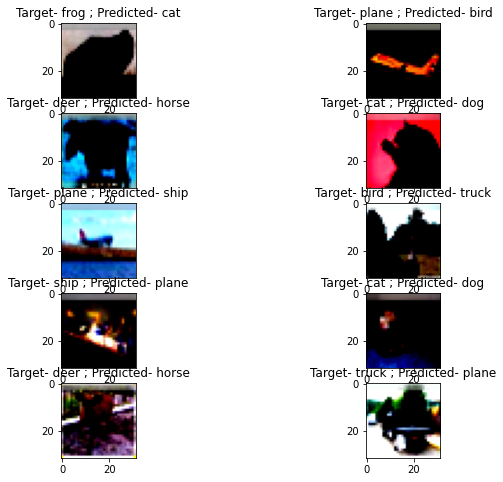



 crosstab of incorrect prediction to understand patterns: 



Predicted,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
Actual,,,,,,,,,,
bird,0,0,18,36,12,27,5,25,2,2
car,0,0,1,0,0,1,0,4,3,27
cat,23,2,0,23,77,24,15,9,3,7
deer,18,1,20,0,11,13,16,3,1,1
dog,16,0,98,12,0,10,13,1,0,2
frog,12,1,13,10,0,0,2,3,2,1
horse,10,0,10,18,19,1,0,6,0,3
plane,17,7,10,2,2,6,0,0,21,16
ship,3,5,3,0,0,3,1,22,0,10


In [19]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10) # test misclassified images and crosstab report

In [25]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=90cb9fdb8f8591e1b4ad66fe7168daf591d26e7d0423165ee37315f24824d52a
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [22]:
net.eval()

Custom_ResNet(
  (preplayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): LayerBlock(
    (conv_pool): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (residualblock): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

## using pytorch-grad-cam
https://jacobgil.github.io/pytorch-gradcam-book/introduction.html


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


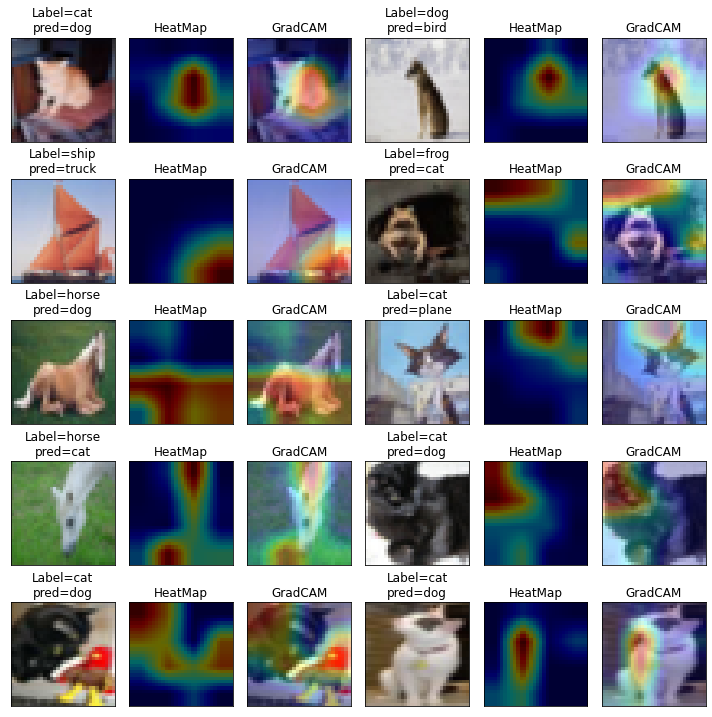

In [29]:
# Using gradcam from utility
from utils import plotGradCAM
# for layer3
plotGradCAM(net, testloader, target_classes, device, 'layer3')

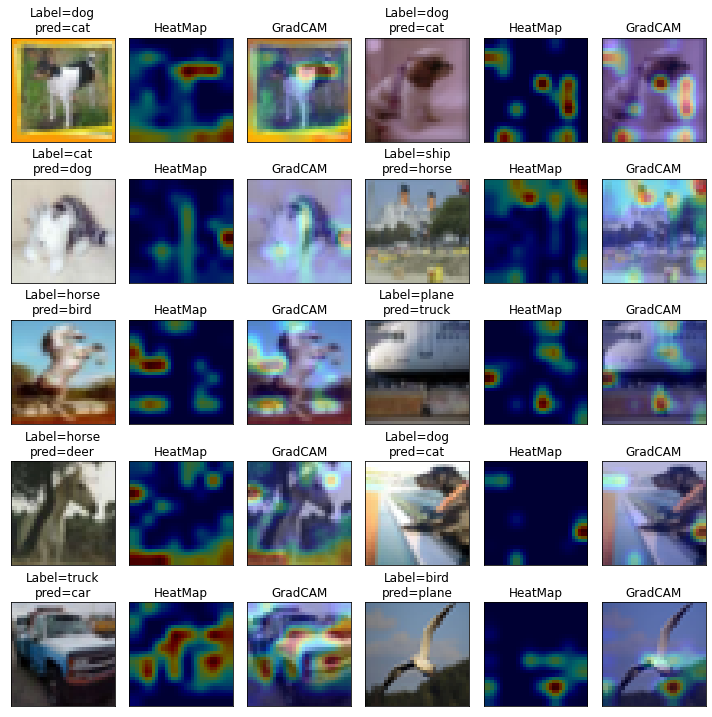

In [31]:
# for layer2
plotGradCAM(net, testloader, target_classes, device, 'layer2')

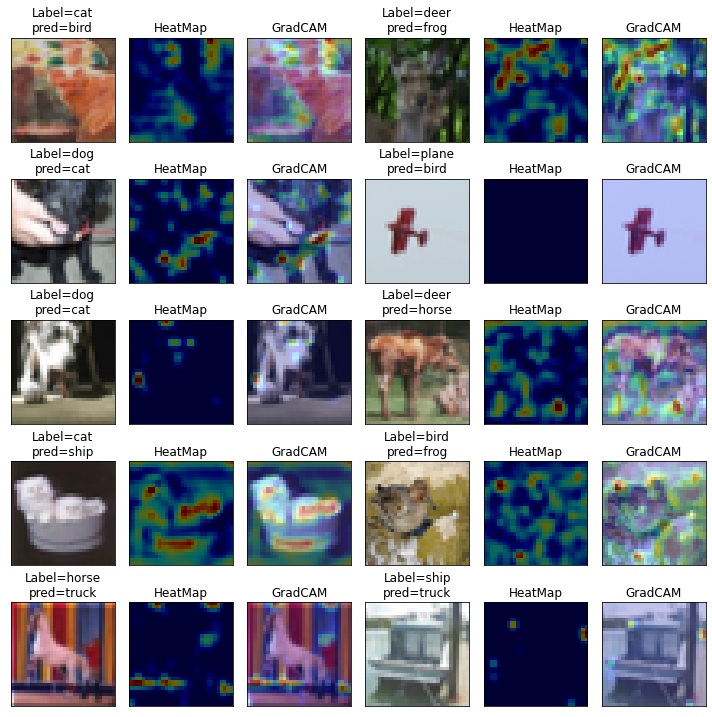

In [32]:
# for layer1
plotGradCAM(net, testloader, target_classes, device, 'layer1')

##END